In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import AnaUtils as au
import Triggered as tr
import glob
import os
import scipy as sp
import awkward as awk
from pylab import rcParams
rcParams['figure.figsize'] = 15, 11

In [2]:
winS = 5
winF = 6
QDict,waveInfo = tr.extRun("testdata/test3",30,winS,winF,qW=0.05,ret=True)
QDict,waveInfo

{'numEvents': 100000, 'numSamples': 4000, 'chMap': array([1, 0, 1]), 'numChan': 2, 'file': 'testdata/test3', 'liveTimes_s': array([1.50833333e-06, 7.91559667e-03, 3.53367167e-03, ...,
       3.60268167e-03, 3.87928000e-03, 3.81171500e-03]), 'totliveTime_s': 371.14965455666663}


({'qData': array([-0.00813802,  0.07324219,  0.00813802, ..., -0.12207031,
         -0.40690104,  0.29296875]),
  'qHist': (array([5.38543683e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 5.38543683e-02, 5.38543683e-02, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          5.38543683e-02, 0.00000000e+00, 0.00000000e+00, 1.07708737e-01,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          5.38543683e-02, 0.00000000e+00, 0.00000000e+00, 5.38543683e-02,
          0.00000000e+00, 5.38543683e-02, 0.00000000e+00, 5.38543683e-02,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          5.38543683e-02, 0.00000000e+00, 0.00000000e+00, 0.00000

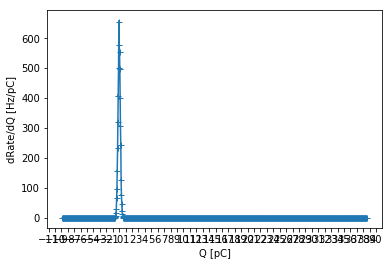

In [3]:
def plotQ(qhist,xbase = 1.0):
    plt.clf()
    
    ax = plt.errorbar(qhist[1],qhist[0],marker='+',yerr=np.sqrt(qhist[2]))
    plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(xbase))
    plt.xlabel('Q [pC]')
    plt.ylabel('dRate/dQ [Hz/pC]')
    #plt.savefig(sdir+"/dQHist.png")
    plt.show()
plotQ(QDict['qHist'],1)

In [4]:
from scipy import signal

ksigma = 3.5
scale = 5
ksize = ksigma*scale
Lkernel = au.LoGkernel(ksigma,scale=scale)
LoGL = signal.fftconvolve(QDict['waves'],Lkernel[np.newaxis,...],mode='full',axes=1)[:,int(ksize/2):-int(ksize/2)]

[-8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.]
[ 0.34485631  0.24489796  0.15826739  0.0849646   0.02498959 -0.02165764
 -0.05497709 -0.07496876 -0.08163265 -0.07496876 -0.05497709 -0.02165764
  0.02498959  0.0849646   0.15826739  0.24489796  0.34485631]


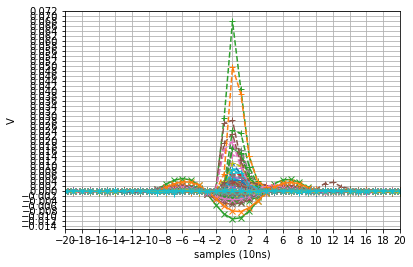

In [5]:
for i in range(100):
    if int(LoGL[i].max())<0.5:
        x=np.arange(waveInfo['numSamples'])-np.argmax(QDict['waves'][i])
        p=plt.plot(x,QDict['waves'][i],marker='+',label=i,linestyle='dashed')
        plt.plot(x,LoGL[i],marker='x',label='{}LoG'.format(i),color=p[-1].get_color())
        #plt.plot(x,LoGL[i]*scale,marker='x',label='{}LoGR'.format(i))
plt.xlabel('samples (10ns)')
plt.ylabel('V')
plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(2e-3))
plt.grid()
plt.xlim((-20,20))
#plt.legend()
plt.show()
#input('Cont...')

In [ ]:
def zero_crossing(mLoG,mWave,thresh,window=3):
    maxL,minL,gradL = au.mmg_rolling(mLoG,window)
    #print(grad2L,gradL)
    pzero = (mLoG[...,1:-1]>0)
    zeroCross = np.zeros(shape=mLoG.shape).astype(np.int)
    zeroCross[...,1:-1] = pzero*(minL<0) + (1-pzero)*(maxL>0)
    diffL = maxL-minL
    zeroCross[...,1:-1] = zeroCross[...,1:-1]*(diffL > thresh)
    zeroCross[...,1:-1] = ((gradL>thresh/window).astype(np.int)-(gradL<-thresh/window).astype(np.int))*zeroCross[...,1:-1]
    cDiff = mLoG-mWave
    cDiff *= np.abs(cDiff)>thresh
    curveInt = np.diff(np.sign(cDiff))
    #curveInt = zeroCross[...,:-1]*(curveInt!=0)
    #zeroCross[...,:-1] *= (curveInt!=0)
    #zeroCross[zeroCross==0] = np.nan
    lEd = awk.fromiter([np.nonzero(zi)[0] for zi in zeroCross<0])
    rEd = awk.fromiter([np.nonzero(zi)[0] for zi in zeroCross>0])
    return (lEd,rEd),np.pad(gradL,[(0,)]*(gradL.ndim-1)+[(1,)],'constant',constant_values=(0)),awk.fromiter([np.nonzero(ci)[0] for ci in curveInt])
    
#Find intersection points, intersections corresponding to zero crossings are used as edge candidates
th = 0.3
zeroCross,zeroGrad,curveInt = zero_crossing(LoGL,QDict['waves'],th*1e-3)
zeroCross,zeroGrad,curveInt

In [ ]:
nwa=500
cols=np.empty(nwa,dtype=object)
ncross = (zeroCross[0].counts,zeroCross[1].counts)
for i in range(nwa):
    qmax = QDict['waves'][i].max()
    if QDict['qData'][i]>0.25:
        x=np.arange(waveInfo['numSamples'])-np.argmax(QDict['waves'][i])
        p=plt.plot(x,LoGL[i],marker='x',linestyle='dashed',label='i{}_l{}_r{}_q{}'.format(i,ncross[0][i],ncross[1][i],QDict['qData'][i]))
        cols[i]=p[-1].get_color()
        plt.plot(x,QDict['waves'][i],marker='+',color=cols[i])
        plt.plot(curveInt[i]-np.argmax(QDict['waves'][i]),QDict['waves'][i][curveInt[i]],linestyle='None',marker='o',color='red')
        #plt.vlines(np.nonzero(zeroCross[0][i])[0]-np.argmax(testEv2[i]),-testEv2[i].max(),testEv2[i].max())
        plt.vlines(zeroCross[0][i]-np.argmax(QDict['waves'][i]),-qmax,qmax,linestyles='dashed')
        plt.vlines(zeroCross[1][i]-np.argmax(QDict['waves'][i]),-qmax,qmax,linestyles='dotted')
        plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
        plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(np.max(QDict['waves'][i])/10))
        plt.grid()
        plt.xlim((-20,20))
        plt.legend()
        plt.show()

In [8]:
bigcross = (np.nonzero(ncross[0]>2)[0],np.nonzero(ncross[1]>2)[0])
bigcross

(array([    6,    19,    22, ..., 99976, 99978, 99999]),
 array([    6,    19,    22, ..., 99990, 99991, 99999]))

In [ ]:
ev = 731
tL = zeroCross[0][ev]
tR = zeroCross[1][ev]
tL,tR

In [ ]:
import itertools
a= []
a = list(itertools.chain.from_iterable([[(tLi,tRi) for tRi in tR[np.nonzero(tR>tLi)[0]]] for tLi in tL]))
#b = [(ai[0],ai[1][n]) for ai,n in itertools.product(a,len(ai))]
a

In [ ]:
tL[1:]-tL[:-1]==1

In [ ]:
ppairs = [(tL[i],tR[i]) for i in ]

In [ ]:
def pair_edges(tL,tR,wave):
    ppairs = list(itertools.chain.from_iterable([[(tLi,tRi) for tRi in tR[np.nonzero(tR>tLi)[0]]] for tLi in tL]))
    pair_ints = [integrate.simps(wave[ppi[0]:ppi[1]]) for ppi in ppairs]
    
    